# MovieRecommender

### A ai-based movie recommendation system trained with MovieLens dataset


## The dataset - a brief description

To train a neural network, which should be able to recommend you good movies based on your rating-history, a large-scale dataset is needed. Therefore the [MovieLens 100K](https://grouplens.org/datasets/movielens/100k/) dataset is used. It contains:
- 100.000 Ratings, each rating contains a one-to-five-star rating made by one user (with userID XY) on one movie (with userID YZ).
- 943 Users, labeled with an userID, age, gender, occupation and zip-code
- 1682 Movies, labeled with an movieID, title, release dates, IMDb URL and a list of genres

You can find the full documentation of the dataset structure under ML_100_INFO.md


### Acknowledgement

The dataset was published here:
F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets:
History and Context. ACM Transactions on Interactive Intelligent
Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages.
DOI=http://dx.doi.org/10.1145/2827872



## The idea: Genre-based recommendation
### Goal
The goal of the recommender system is to predict the best movie recommendation for user with respect to his ratings on other movies and the movie-ratings of other users in general. The easiest way to determine the "best" movie is to predict the users rating on unwatched movies and pick the highest rated one. In this project the influence of the genre-information on the recommendation outcome is investigated by comparing different approaches. The initial spark for this notebook was a genre-correlation model introduced by Sang-Min Choi, Sang-Ki Ko and Yo-Sub Han in 2012. (See: A movie recommendation algorithm based on genre correlations PDF) They calculated an estimated movie rating using the correlation between different genres and using the users rated movies. Here this idea is supplemented by deep learning.
### First approach: Genre-preferences calculation
The first idea to predict the users rating was to calculate every users preferences based on his rating-history and then train a classical dense neural-network with it:

![Model 1 with preference calculation](Model_1_pref.png "Model 1")

First the genre-preference calculation has to be done. The output of it should be a weighted genre list containg values in \[0,1]
The input of the nn is defined by the count of genres: 18 movie genres + 18 preference-weighted genres
The output should be an estimated rating.
### Second approach: Genre-preference-difference calculation
As getting the connection between the right input values might be difficult while training (cold start problem), the second approach was to "help" with the preference-movie relation by inputting the difference between every preference and movie-genre:

![Model 2 with difference calculation](Model_2_diff.png "Model 2")

The input of the nn should be the size of the difference-vector.

### Importing data

First the data musst be imported in a usable dataformat to do some pre-processing. Also some analyzation can be done to get a feeling for the dataset, its content, diversity and limitations.
To access the data its useful to define some classes: (LEARNING: Better just use pandas_df...)

In [44]:
import DataClasses

Learning after defining classes: Better just use pandas-dataframes for storing and accessing data
Then its time to start importing the dataset (and required modules)

In [2]:
#Module Imports
import pandas as pd
import csv
from zipfile import  ZipFile
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
#Dataset import
IMPORT_ONLINE = False

# DataClasses.importAsDataClasses() #First import-attempt without pandas, worked but not used bc too complicated

if(IMPORT_ONLINE): #Copied online import from https://keras.io/examples/structured_data/collaborative_filtering_movielens/
    # Download the actual data from http://files.grouplens.org/datasets/movielens/ml-100k.zip
    # Use the ratings.csv file
    movielens_data_file_url = (
        "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
    )
    movielens_zipped_file = keras.utils.get_file(
        "ml-100k.zip", movielens_data_file_url, extract=False
    )
    keras_datasets_path = Path(movielens_zipped_file).parents[0]
    movielens_dir = keras_datasets_path / "ml-100k"

    # Only extract the data the first time the script is run.
    if not movielens_dir.exists():
        with ZipFile(movielens_zipped_file, "r") as zip:
            # Extract files
            print("Extracting all the files now...")
            zip.extractall(path=keras_datasets_path)
            print("Done!")
    data_dir = movielens_dir

else:
    data_dir = Path("ml-100k")

ratingFile = data_dir / "u.data"
df_ratings = pd.read_csv(ratingFile, delimiter='\t', encoding="latin",names=["userId","movieId","rating","t_stamp"],index_col=False)
movieFile = data_dir / "u.item"
# print(df_ratings)
df_movies = pd.read_csv(movieFile, delimiter='|', encoding="latin",names=["id","title","date","v_date","url","unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"])
# print(df_movies)
print(f"Sanity check:\nThe movie {df_movies['title'][212]} contains the genres: {[df_movies.columns[i] for i in range(len(df_movies.columns)) if df_movies.iloc[212][df_movies.columns[i]] == 1]}")
userFile = data_dir / "u.user"
df_users = pd.read_csv(userFile, delimiter='|', encoding="latin",names=["userId","age","gender","occupation","zip"])
# print(df_users)
print(f"Sanity check:\nThe user 111 ({df_users['gender'][110]} {df_users['age'][110]}) works as {df_users['occupation'][110]} - ID: {df_users['userId'][110]}")

4924029/4924029 [==============================] - 2s 0us/step
Extracting all the files now...
Done!
Sanity check:
The movie Room with a View, A (1986) contains the genres: ['Drama', 'Romance']
Sanity check:
The user 111 (M 57) works as engineer - ID: 111


## Analyzation
With focus on genre-distribution.
As the network should rate movies based on genre-information, it is useful to first have a look at the movielens data - especally the genre data. Therefore the rating distribution of all users, the genre-distribution over all films and the most watched genres (absolut and weighted by rating) are analysed:

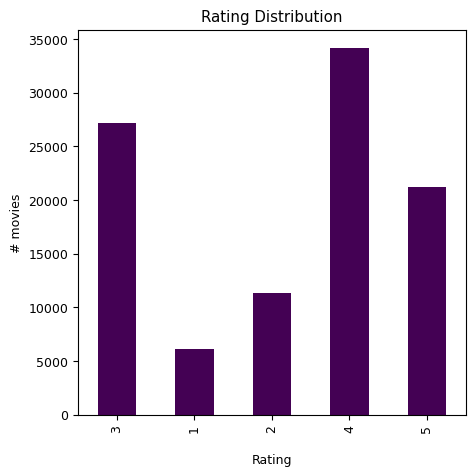

<Figure size 1000x1000 with 0 Axes>

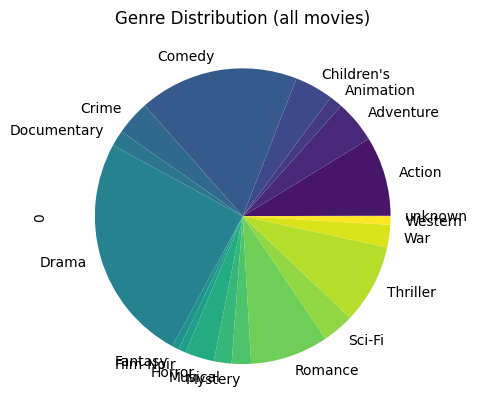

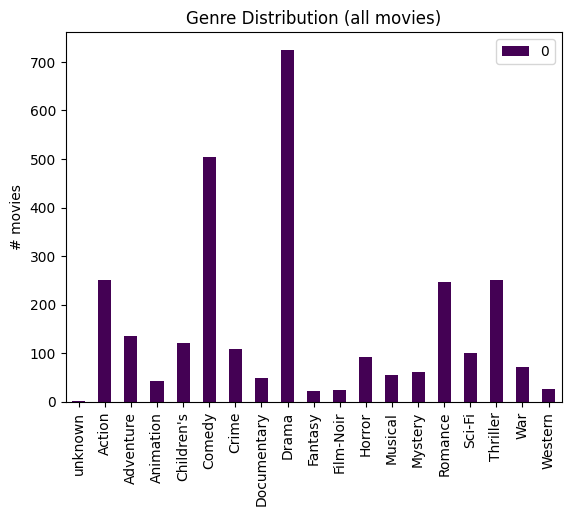

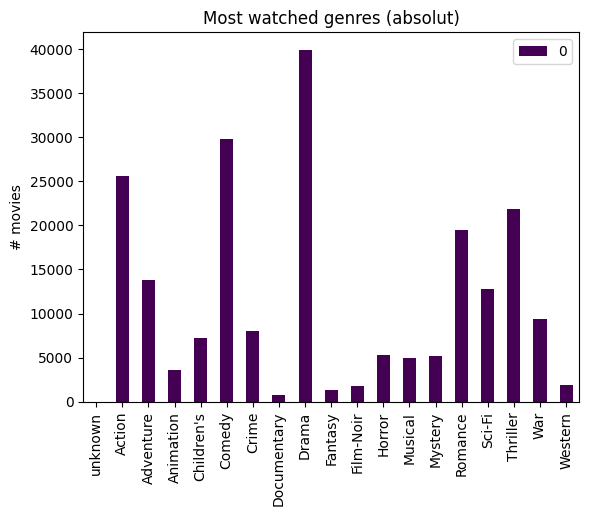

In [162]:
# Analyse: Best Movie, average ratings, average rating counts,
#rating distribution
plt.figure(figsize=(5,5))
plt.rc("font", size=9)
df_ratings.rating.value_counts(sort=False).plot(kind='bar', colormap = mpl.colormaps['viridis'])
plt.title('Rating Distribution')
plt.xlabel('\nRating')
plt.ylabel('# movies')
plt.show()
#genre-distribution
plt.figure(figsize=(10,10))
plt.rc("font", size=10)
genres_sum_movies = [sum(np.asarray(df_movies.loc[:,col])) for col in df_movies.columns[5:24].values]
df_genres = pd.DataFrame(genres_sum_movies,index= df_movies.columns[5:24].values)
df_genres.plot(kind='pie', colormap = mpl.colormaps['viridis'], subplots=True, legend=False)
plt.title('Genre Distribution (all movies)')
df_genres.plot(kind='bar', colormap = mpl.colormaps['viridis'])
plt.ylabel('# movies')
plt.title('Genre Distribution (all movies)')
plt.show()
#mostwatched genres
genres = [df_movies.loc[int(movieId)-1,'unknown':'Western'].tolist() for movieId in df_ratings['movieId']] # might take 1 minute..
genres = np.asarray(genres)
genres_sum = [sum(genres[:,col]) for col in range(19)]
df_genres = pd.DataFrame(genres_sum,index= df_movies.columns[5:24].values)
df_genres.plot(kind='bar', colormap = mpl.colormaps['viridis'])
plt.title('Most watched genres (absolut)')
plt.ylabel('# movies')
plt.show()

## Preprocessing
After successfully importing all relevant data, the next step is to pre-process the data so it fits our nn-input. In total there are two dataset-variations defined, referring the two approaches:
1. x_pref       (preferred genres + movie genres)
2. x_pref_diff  (difference between preferred and movie genres)
- y is always the given rating


## Preference Calculation

In [89]:
#User genre preference calculation based on all other ratings in the training set
def calc_pref(userID, movieID, count=0):
    #get all ratings:
    user_ratings = df_ratings.loc[(df_ratings["userId"] == userID) & (df_ratings["movieId"] != movieID)]
    user_movies = df_movies.loc[df_movies["id"].isin(user_ratings["movieId"])]
    # print(user_movies)
    # add rating in correct order
    user_rating_sorted = [int(user_ratings.loc[(user_ratings["movieId"]==id),"rating"]) for id  in user_movies["id"]]
    genre_table = user_movies.loc[:,"unknown":"Western"]# #only genres
    num_movies = len(user_movies)
    if num_movies:
        g_mat = genre_table.to_numpy()
        r_mat = np.asarray(user_rating_sorted)
        r_mat = np.tile(r_mat, (19,1))
        # multiply with rating
        g_mat = g_mat * r_mat.transpose() / 5 #weight g_mat with rating
        pref_mat = np.asarray([np.sum(g_mat[:,i]) for i in range(np.shape(g_mat)[1])])
        pref_mat = pref_mat / num_movies #normalize to num_movies
        # print(g_mat, r_mat, g_mat*r_mat.transpose())
        return pref_mat
    else:
        return 0

      unknown  Action  Adventure  Animation  Children's  Comedy  Crime  \
1           0       1          1          0           0       0      0   
3           0       1          0          0           0       1      0   
16          0       1          0          0           0       1      1   
20          0       1          1          0           0       1      0   
23          0       1          1          0           0       0      1   
...       ...     ...        ...        ...         ...     ...    ...   
998         0       0          0          0           0       1      0   
999         0       0          0          0           0       1      0   
1000        0       0          0          0           0       1      0   
1001        0       0          0          0           0       1      0   
1002        0       0          0          0           1       1      0   

      Documentary  Drama  Fantasy  Film-Noir  Horror  Musical  Mystery  \
1               0      0        0    

<AxesSubplot: >

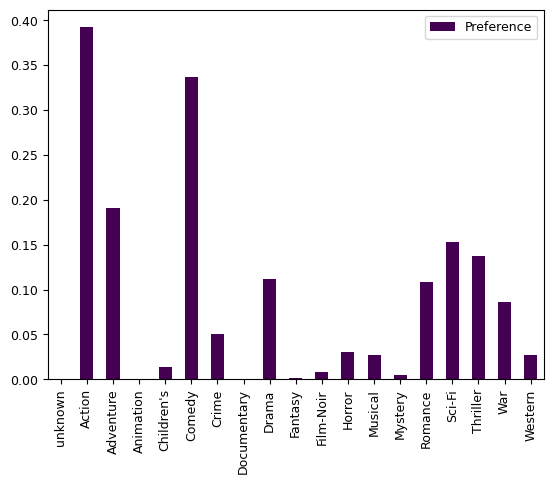

In [90]:
df_test = pd.DataFrame(calc_pref(22,377),index= df_movies.columns[5:24].values,columns=["Preference"])
print(f"Sanity check: User 22 has preference for genres:\n") #'{df_test}") #uncomment to see calculated values
df_test.plot(kind='bar',colormap = mpl.colormaps['viridis'])

### Dataset augmentation x_pref & x_pref_dif
Before the implemented nn-model can be trained, the ratings-data will be augmented by the genre-information. Hence, userId and movieId are replaced with the preferred genres of the user and genre list of the movie. Because of this math-intensive task (preferences are calculated with all other movies), the dataset is split into two parts. After completing the task, the calculated data is stored in a csv-file so it dont have to be calculated every time and can be imported directly afterwards.

In [ ]:
num_samples = len(df_ratings) # splitting because of intensive task (1h each)
num_samples_half = int(num_samples/2)
# x contains: [user_preferences movie_genres]
x1 = [[calc_pref(df_ratings.loc[i,"userId"],df_ratings.loc[i,"movieId"] ,i).tolist(),
       df_movies.loc[df_ratings.loc[i,"movieId"]-1, "unknown":"Western"].values.tolist()] for i in range(num_samples_half)]
# y contains: [rating]
y1 = [df_ratings.iloc[i,2] for i in range(num_samples_half)]

#save:
with open('x1_1_data.csv', 'w', newline="") as f: #) as f: #
    writer = csv.writer(f, dialect='excel')
    for i in range(num_samples_half):
        row = x1[i][0] + x1[i][1]
        writer.writerow(row)
with open('y1_1_data.csv', 'w', newline="") as f:
    writer = csv.writer(f, dialect='excel')
    for i in range(num_samples_half):
        row = [y1[i]]
        writer.writerow(row)

In [ ]:
x2 = [[calc_pref(df_ratings.loc[i,"userId"],df_ratings.loc[i,"movieId"] ,i).tolist(),
       df_movies.loc[df_ratings.loc[i,"movieId"]-1, "unknown":"Western"].values.tolist()] for i in range(num_samples_half,num_samples)]

y2 = [df_ratings.iloc[i,2] for i in range(num_samples_half,num_samples)]

with open('x2_1_data.csv', 'w', newline="") as f: #) as f: #
    writer = csv.writer(f, dialect='excel')
    for i in range(num_samples_half):
        row = x2[i][0] + x2[i][1]
        writer.writerow(row)
with open('y2_1_data.csv', 'w', newline="") as f:
    writer = csv.writer(f, dialect='excel')
    for i in range(num_samples_half):
        row = [y2[i]]
        writer.writerow(row)

In [132]:
#Bring together and save:
x = x1 + x2
y = y1 + y2

with open('x_1_data.csv', 'w', newline="") as f: #) as f: #
    writer = csv.writer(f, dialect='excel')
    for i in range(num_samples):
        row = x[i][0] + x[i][1]
        writer.writerow(row)
with open('y_1_data.csv', 'w', newline="") as f:
    writer = csv.writer(f, dialect='excel')
    for i in range(num_samples):
        row = [y[i]]
        writer.writerow(row)

In [13]:
#Read saved preferences for not calculating again:
saved_dir = Path("aug_data")
xFile = saved_dir  / "x_1_data.csv"
df_x_pref = pd.read_csv(xFile, encoding="latin",names=range(38))
print(df_x_pref.iloc[1])
x_pref_list = df_x_pref.values.tolist()
yFile = saved_dir  / "y_1_data.csv"
df_y = pd.read_csv(yFile, encoding="latin",names=range(1))
y_list = df_y.values.tolist()

0     0.000000
1     0.235165
2     0.098901
3     0.039560
4     0.074725
5     0.085714
6     0.074725
7     0.000000
8     0.195604
9     0.010989
10    0.010989
11    0.004396
12    0.035165
13    0.076923
14    0.052747
15    0.046154
16    0.395604
17    0.013187
18    0.030769
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
24    0.000000
25    1.000000
26    0.000000
27    0.000000
28    0.000000
29    1.000000
30    0.000000
31    0.000000
32    1.000000
33    0.000000
34    0.000000
35    1.000000
36    0.000000
37    0.000000
Name: 1, dtype: float64


In [52]:
num_samples = 100000
x_pref = np.asarray(x_pref_list)
x_pref_diff = list()
y = np.asarray(y_list)
for i in range(num_samples):
    x_pref_diff.append(1 - abs(x_pref[i,19:37]- x_pref[i,0:18])) #calculated difference and map it to d=0 -> 1 and d=1 -> 0 (inverse)
x_pref_diff = np.asarray(x_pref_diff)

In [53]:
# normalize y
y = (y -1)/4

In [55]:
#splitting to x_train and x_test:
n_rand = np.random.rand(len(x_pref)) <= 0.8

# Preferences:
x_pref_train = x_pref[n_rand]
x_pref_test = x_pref[~n_rand]
# Differing preferences:
x_pref_diff_train = x_pref_diff[n_rand]
x_pref_diff_test = x_pref_diff[~n_rand]

y_train = y[n_rand]
y_test = y[~n_rand]
print(np.shape(x_pref_test), np.shape(x_pref_train), np.shape(y_test), np.shape(y_train))

(20078, 38) (79922, 38) (20078, 1) (79922, 1)


## Setting up the nn models:

There are two models, one for each approach. Model 1 (Pref) and Model 2 (Pref-Dif) differ in their input sizes.

In [56]:
# Network to estimate user rating based on genre preferences:
rater_model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape = x_pref.shape[1]),
  tf.keras.layers.Dense(76, activation='relu'),
  tf.keras.layers.Dense(38, activation='relu'),
  tf.keras.layers.Dense(1, activation='relu'),
])
rater_model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 76)                2964      
                                                                 
 dense_7 (Dense)             (None, 38)                2926      
                                                                 
 dense_8 (Dense)             (None, 1)                 39        
                                                                 
Total params: 5,929
Trainable params: 5,929
Non-trainable params: 0
_________________________________________________________________


In [70]:
rater_model_2 = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape = x_pref_diff.shape[1]),
  tf.keras.layers.Dense(76, activation='relu'),
  tf.keras.layers.Dense(38, activation='relu'),
  tf.keras.layers.Dense(1, activation='relu'),
])

## Training

In [62]:
rater_model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
              loss= tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [71]:
rater_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
              loss= tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [63]:
history1 = rater_model_1.fit(
    x_pref_train,
    y_train,
    epochs=40,
    batch_size=50,
    validation_data=(x_pref_test, y_test)
)

Epoch 1/40
1599/1599 [==============================] - 18s 10ms/step - loss: 0.0662 - accuracy: 0.2315 - val_loss: 0.0651 - val_accuracy: 0.2276
Epoch 2/40
1599/1599 [==============================] - 16s 10ms/step - loss: 0.0660 - accuracy: 0.2321 - val_loss: 0.0649 - val_accuracy: 0.2268
Epoch 3/40
1599/1599 [==============================] - 15s 10ms/step - loss: 0.0660 - accuracy: 0.2322 - val_loss: 0.0698 - val_accuracy: 0.2261
Epoch 4/40
1599/1599 [==============================] - 16s 10ms/step - loss: 0.0655 - accuracy: 0.2322 - val_loss: 0.0640 - val_accuracy: 0.2291
Epoch 5/40
1599/1599 [==============================] - 17s 11ms/step - loss: 0.0653 - accuracy: 0.2327 - val_loss: 0.0652 - val_accuracy: 0.2266
Epoch 6/40
1599/1599 [==============================] - 18s 11ms/step - loss: 0.0657 - accuracy: 0.2327 - val_loss: 0.0696 - val_accuracy: 0.2258
Epoch 7/40
1599/1599 [==============================] - 24s 15ms/step - loss: 0.0652 - accuracy: 0.2330 - val_loss: 0.0640 -

In [72]:
history2 = rater_model_2.fit(
    x_pref_diff_train,
    y_train,
    epochs=40,
    batch_size=50,
    validation_data=(x_pref_diff_test, y_test)
)

Epoch 1/40
1599/1599 [==============================] - 6s 3ms/step - loss: 0.0843 - accuracy: 0.2113 - val_loss: 0.0772 - val_accuracy: 0.2099
Epoch 2/40
1599/1599 [==============================] - 3s 2ms/step - loss: 0.0777 - accuracy: 0.2125 - val_loss: 0.0773 - val_accuracy: 0.2099
Epoch 3/40
1599/1599 [==============================] - 3s 2ms/step - loss: 0.0777 - accuracy: 0.2128 - val_loss: 0.0762 - val_accuracy: 0.2099
Epoch 4/40
1599/1599 [==============================] - 3s 2ms/step - loss: 0.0774 - accuracy: 0.2126 - val_loss: 0.0775 - val_accuracy: 0.2099
Epoch 5/40
1599/1599 [==============================] - 4s 2ms/step - loss: 0.0771 - accuracy: 0.2125 - val_loss: 0.0769 - val_accuracy: 0.2099
Epoch 6/40
1599/1599 [==============================] - 4s 3ms/step - loss: 0.0773 - accuracy: 0.2125 - val_loss: 0.0771 - val_accuracy: 0.2099
Epoch 7/40
1599/1599 [==============================] - 4s 2ms/step - loss: 0.0772 - accuracy: 0.2125 - val_loss: 0.0758 - val_accuracy:

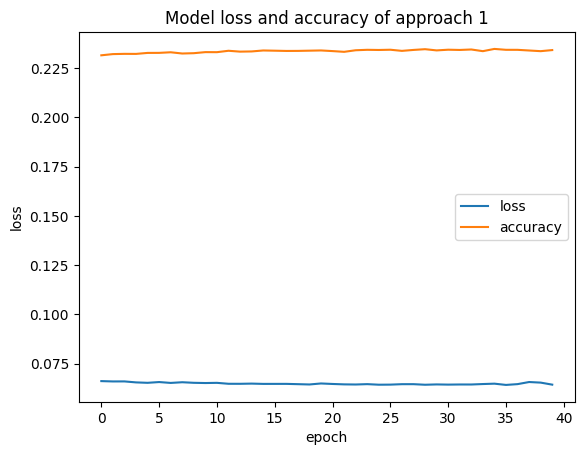

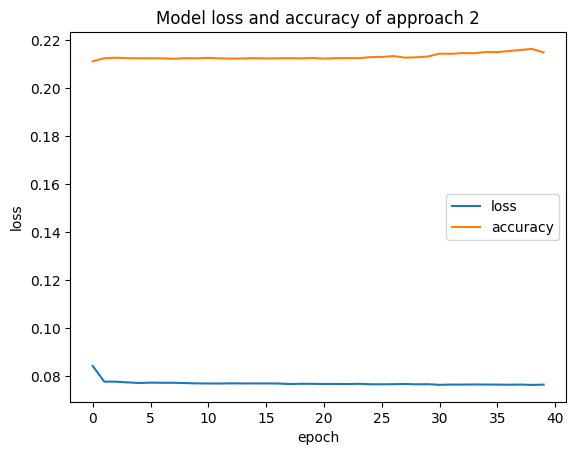

In [74]:
#Plot training data:
plt.plot(history1.history["loss"])
plt.plot(history1.history["accuracy"])
plt.title("Model loss and accuracy of approach 1")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["loss", "accuracy"], loc="best")
plt.show()

plt.plot(history2.history["loss"])
plt.plot(history2.history["accuracy"])
plt.title("Model loss and accuracy of approach 2")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["loss", "accuracy"], loc="best")
plt.show()

## Conclusion

The accuracy of both approaches/models stays verry low. An accuracy of ~0.23 means, that the model is not much better than barely guessing the rating. After trying different losses, layers, learning-rate/batchsize/epoch-counts and checking the corect input-vector-relations the accuracy couldn't be raised over that 0.23 mark. Arguing that more epochs, a slight change in the architecture or a different loss would have raised higher accuracy seems unconvincing, because at some point the accuracy would have increased at least to 0.25 or 0.3 - if there was a reasonable correlation between both inputs. Looking at some data give a hint on the problem. Comparing some ratings with their achieved similarity (sum of all preference-movie-similarities) shows that there is not even a small correlation:

<AxesSubplot: >

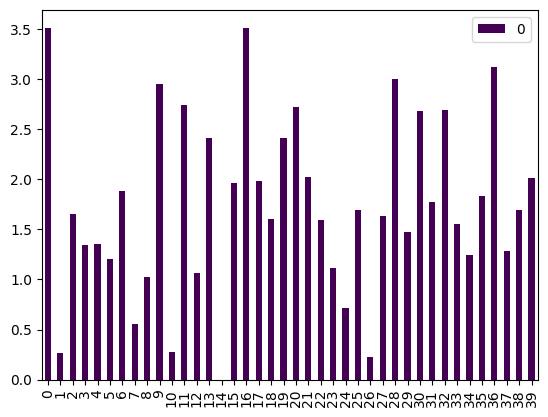

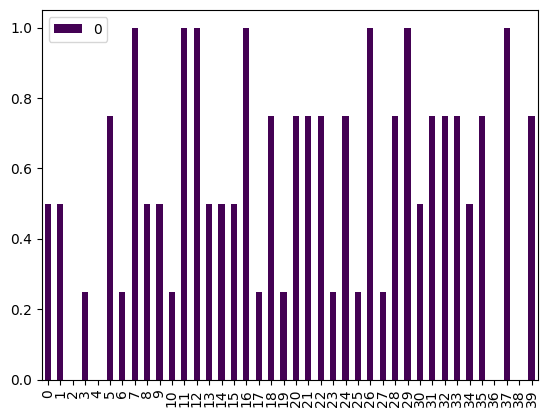

In [68]:
summ = [sum(row) for row in x_pref_diff[:40]]
summ = summ - min(summ)
df_sum = pd.DataFrame(list(summ))
df_sum.plot(kind='bar',colormap = mpl.colormaps['viridis'])
df_sum2 = pd.DataFrame(y[:40])
df_sum2.plot(kind='bar',colormap = mpl.colormaps['viridis'])

# Findings and outlook
For now the finding of this project is: The genre preferences of users are not directly linked with their ratings and the movie-genres of the rated film. That could come from different reasons. One point is, that users are more critical with movies of their preferred genres. Also sparely watched genres are underrepresented: Not watching a genre verry often, doesn't imply that the user would give it a bad rating!

As next step other preference calculations could be implemented. For example defining the users preferences by calculation an average-raating for every genre. That would fade the frequency a user watches certain genres and stretch the fact how he rates a genre. Furthermore the use of collaborative filtering techniques is something to think about. (But wasnt something I wantend to copy from Keras ;) )